# SARIMA with eXogenous data (SARIMAX)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import warnings
import math
import itertools
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Prepare Data

In [3]:
with open('/content/drive/Shareddrives/DATA_SCI-2020-2/PM2.5/PM2.5-data/Bangkok.txt','r') as f:
    for i in range(12):
        print(f.readline())

FileNotFoundError: ignored

In [ ]:
bkk_pm25 = pd.read_csv('/content/drive/Shareddrives/DATA_SCI-2020-2/PM2.5/PM2.5-data/Bangkok.txt', sep='\t', header=None, skiprows=10)
bkk_pm25

,0,1,2,3,4,5,6
0,2016,3,3,8,62.9,1.0,0
1,2016,3,3,9,62.9,1.0,0
2,2016,3,3,10,55.5,1.0,0
3,2016,3,3,11,55.5,1.0,0
4,2016,3,3,12,47.9,1.0,0
...,...,...,...,...,...,...,...
31141,2020,3,18,9,23.9,0.0,0
31142,2020,3,18,10,24.4,0.0,0
31143,2020,3,18,11,24.9,0.0,0
31144,2020,3,18,12,27.0,0.0,0


In [ ]:
bkk_pm25['Time'] = pd.to_datetime({'year': bkk_pm25[0], 'month': bkk_pm25[1], 'day':bkk_pm25[2],'hour': bkk_pm25[3]})

bkk_pm25['Time'] = bkk_pm25['Time'].dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
bkk_pm25['Time'] = bkk_pm25['Time'].dt.tz_localize(None)

bkk_pm25=bkk_pm25.drop([0,1,2,3,5,6],axis=1)
bkk_pm25.columns = ['PM2.5(µg/m3)', 'Time']
bkk_pm25 = bkk_pm25.set_index('Time')

bkk_pm25

,PM2.5(µg/m3)
Time,
2016-03-03 15:00:00,62.9
2016-03-03 16:00:00,62.9
2016-03-03 17:00:00,55.5
2016-03-03 18:00:00,55.5
2016-03-03 19:00:00,47.9
...,...
2020-03-18 16:00:00,23.9
2020-03-18 17:00:00,24.4
2020-03-18 18:00:00,24.9


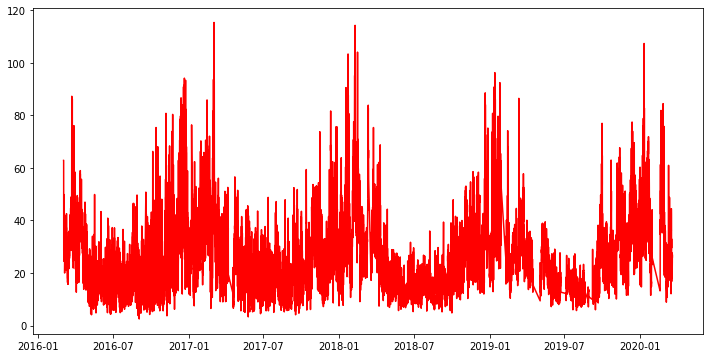

In [ ]:
bkk_pm25 = bkk_pm25[~bkk_pm25.index.duplicated(keep='first')]
bkk_pm25.index = pd.DatetimeIndex(bkk_pm25.index)
bkk_pm25 = bkk_pm25.reindex(pd.date_range("2016-03-03 15:00:00", "2020-03-18 20:00:00",freq='h'), fill_value=np.nan)
bkk_pm25 = bkk_pm25.interpolate()

plt.figure(figsize=(12,6))
plt.plot(bkk_pm25,'r')

In [ ]:
temp_df = pd.read_csv('/content/drive/Shareddrives/DATA_SCI-2020-2/PM2.5/Temp-data/3H_temperature_Bangkok.csv')
temp_df['datetime'] = pd.to_datetime(temp_df['datetime'])
temp_df.set_index(temp_df['datetime'],inplace=True)
temp_df.drop(columns={'datetime'},inplace=True)
temp_df = temp_df.resample('h').ffill()

,Temp(C),lat,long
datetime,,,
2016-01-01 01:00:00,24.8,13.754,100.5014
2016-01-01 04:00:00,23.8,13.754,100.5014
2016-01-01 07:00:00,22.9,13.754,100.5014
2016-01-01 10:00:00,26.4,13.754,100.5014
2016-01-01 13:00:00,30.3,13.754,100.5014
...,...,...,...
2020-12-31 10:00:00,24.3,13.754,100.5014
2020-12-31 13:00:00,28.8,13.754,100.5014
2020-12-31 16:00:00,29.6,13.754,100.5014


In [ ]:
temp_df

,Temp(C),lat,long
datetime,,,
2016-01-01 01:00:00,24.8,13.754,100.5014
2016-01-01 02:00:00,24.8,13.754,100.5014
2016-01-01 03:00:00,24.8,13.754,100.5014
2016-01-01 04:00:00,23.8,13.754,100.5014
2016-01-01 05:00:00,23.8,13.754,100.5014
...,...,...,...
2020-12-31 18:00:00,29.6,13.754,100.5014
2020-12-31 19:00:00,26.4,13.754,100.5014
2020-12-31 20:00:00,26.4,13.754,100.5014


In [ ]:
data = bkk_pm25.merge(temp_df,left_index=True,right_index=True)

In [ ]:
data[['PM2.5(µg/m3)','Temp(C)']]

,PM2.5(µg/m3),Temp(C)
2016-03-31,35.814905,30.238620
2016-04-30,31.561806,32.025000
2016-05-31,16.634745,31.756855
2016-06-30,16.803264,30.157778
2016-07-31,16.533401,29.157258
2016-08-31,18.374664,29.420430
2016-09-30,18.693194,28.535278
2016-10-31,20.859677,28.283333
2016-11-30,27.017986,27.676944
2016-12-31,42.260753,26.877688


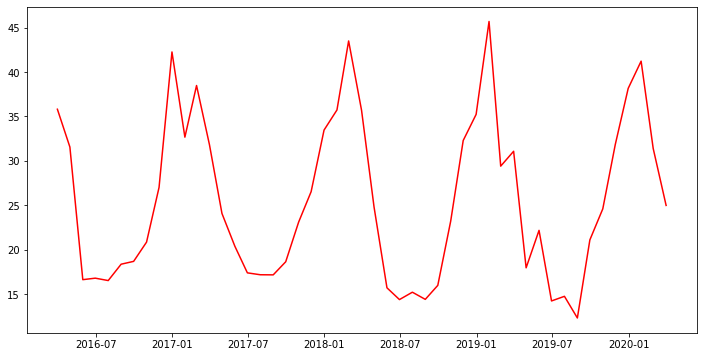

In [ ]:
data = data.resample('M').mean()
plt.figure(figsize=(12,6))
plt.plot(data['PM2.5(µg/m3)'],'r')

#Split data

In [ ]:
data.head()

,PM2.5(µg/m3),Temp(C),lat,long
2016-03-31,35.814905,30.238620,13.754,100.5014
2016-04-30,31.561806,32.025000,13.754,100.5014
2016-05-31,16.634745,31.756855,13.754,100.5014
2016-06-30,16.803264,30.157778,13.754,100.5014
2016-07-31,16.533401,29.157258,13.754,100.5014


In [ ]:
train_size, valid_size, test_size = map(lambda r: int(r*data.shape[0]), (0.6, 0.2, 0.2))

train, valid, test = data.iloc[:train_size], data.iloc[train_size: train_size + valid_size], data.iloc[train_size + valid_size:]

In [ ]:
exog_columns = ['Temp(C)']

#Fit model with exogenous data
We use the best parameter from the previous lab

In [ ]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
best_order = (0, 1, 1)
best_seasonal_order = (1, 1, 0, 12)

In [ ]:
mod = SARIMAX(train['PM2.5(µg/m3)'],
              exog=train[exog_columns],
              order=best_order,
              seasonal_order=best_seasonal_order,
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Temp(C)        3.4121      1.302      2.622      0.009       0.861       5.963
ma.L1          1.0000   3.25e+04   3.07e-05      1.000   -6.38e+04    6.38e+04
ar.S.L12      -0.5528      0.139     -3.971      0.000      -0.826      -0.280
sigma2         1.1090   3.61e+04   3.07e-05      1.000   -7.07e+04    7.07e+04


#Predict on test
Even if it only predicts on the test set, it needs exogenous data in both validation set and test set to continuously make predictions in sequence from training set to validation set and, finally, to test set.<br>
So, here, we concatenate exogenous data in validation set and test set together.

In [ ]:
test_exog = pd.concat((valid[exog_columns], test[exog_columns]), axis=0)

In [ ]:
pred = results.get_prediction(start=test.index[0], end=test.index[-1], exog=test_exog, dynamic=False)
pred_ci = pred.conf_int()

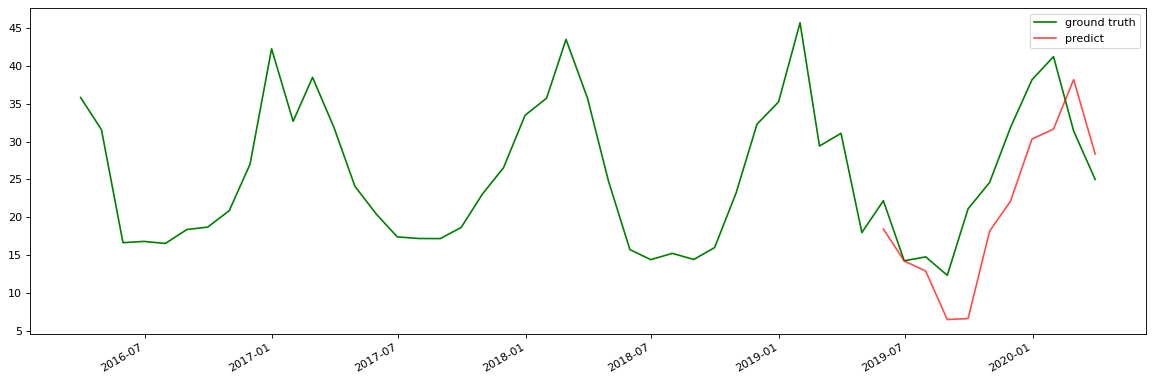

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(data['PM2.5(µg/m3)'], color='g',label='ground truth')
pred.predicted_mean.plot(alpha=.7, color='r',label='predict')
plt.legend(loc="upper right")

plt.show()

In [ ]:
mse = mean_squared_error(test['PM2.5(µg/m3)'], pred.predicted_mean)
rmse = math.sqrt(mse)
print('Test on SARIMAX with RMSE: %f' % (rmse, ))

Test on SARIMAX with RMSE: 16.498914
